### PyTorch Datasets ###

In [47]:
import sys
import os
import glob
import numpy as np
import pandas as pd
import logging
import albumentations as alb
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# From the HuggingFace library
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor
from transformers import TrainingArguments, Trainer

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentex import Dentex
from computervision.imageproc import ImageData, is_image
from computervision.transformations import DETRansform

# Print version info
print(f'Package version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

ModuleNotFoundError: No module named 'transformers'

In [48]:
# Load the image processor from the Hugging Face transformer library
hf_checkpoint = 'PekingU/rtdetr_v2_r101vd'
processor = RTDetrImageProcessor.from_pretrained(hf_checkpoint)

NameError: name 'RTDetrImageProcessor' is not defined

In [22]:
data_dir = os.path.join(os.environ.get('HOME'), 'data')
print(f'data_dir: {data_dir}')

xrays_dir = os.path.join(data_dir, 'dentex', 'cropped')

# Load the annotations with data splits
parquet_file_name = 'train_quadrant_enumeration_dset.parquet'
parquet_file = os.path.join(xrays_dir, parquet_file_name)
try:
    df = pd.read_parquet(parquet_file)
except Exception as e:
    print(f'ERROR: Could not load file: \n {e}')
    print('Make sure to run the first notebook which downloads the data.')

data_dir: /app/data


In [33]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey'):
    offset_xy = (10, 100)
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

In [16]:
# Let's validate the image data before we do anything else
for file_name in df['file_name'].unique():
    bad_files = []
    if not is_image(os.path.join(xrays_dir, file_name)):
        bad_files.append(file_name)
if len(bad_files) == 0:
    print('All files are good!')
else:
    print(f'Could not open these files: \n {bad_files}')

All files are good!


In [23]:
display(df.head())

,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada,dset
0,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",494,1473,train_0_12.png,train_0,12,1,1,11,8,train
1,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",494,1473,train_0_12.png,train_0,12,1,2,12,7,train
2,"[531, 69, 85, 368]","[[587, 437, 616, 357, 607, 72, 534, 69, 531, 4...",494,1473,train_0_12.png,train_0,12,1,3,13,6,train
3,"[457, 31, 115, 403]","[[522, 434, 572, 378, 543, 31, 463, 40, 457, 3...",494,1473,train_0_12.png,train_0,12,1,4,14,5,train
4,"[369, 10, 100, 406]","[[437, 416, 469, 378, 466, 10, 381, 31, 378, 2...",494,1473,train_0_12.png,train_0,12,1,5,15,4,train


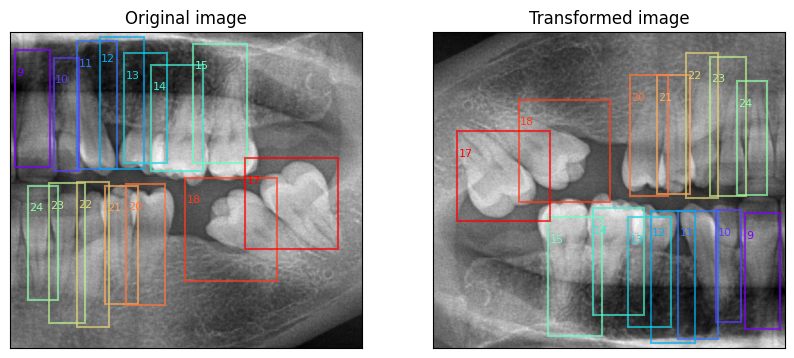

In [45]:
idx = 350
file_list = sorted(list(df['file_name'].unique()))
file = os.path.join(xrays_dir, file_list[idx])
im = ImageData().load_image(file)
bbox_list = df.loc[df['file_name'] == file_name, 'bbox'].tolist()
label_list = df.loc[df['file_name'] == file_name, 'ada'].tolist()

# For demonstration purposes here, flip the image left-right and then up-down:
transformations = [alb.HorizontalFlip(p=1.0), alb.VerticalFlip(p=1)]

# Define the bounding box format
bbox_format = {'format': 'coco',
               'label_fields': ['category_id'],
               'clip': True}

# Apply the transform for this image
detr = DETRansform(transformations=transformations, bbox_format=bbox_format)
transformed_im, annotations = detr.format_transform(image=im, image_id=idx, bboxes=bbox_list, labels=label_list)

# Let's check the output
transformed_bbox_list = [ant['bbox'] for ant in annotations.get('annotations')]
transformed_label_list = [ant['category_id'] for ant in annotations.get('annotations')]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0] = plot_boxes(image=im, box_list=bbox_list, ax=ax[0], label_list=label_list)
ax[0].set(title='Original image')
ax[1] = plot_boxes(image=transformed_im, box_list=transformed_bbox_list, ax=ax[1], label_list=transformed_label_list)
ax[1].set(title='Transformed image')
plt.show()

# Now, we need to process the image using the hugging face transformer